In [1]:
import os
import json
import logging
import openeo
import pyrosm as pyr
import geopandas as gpd
import matplotlib.pyplot as plt

# # Set logging level to info level
# logging.basicConfig(level=logging.INFO)


def setup_logger(name="Task1", level=logging.INFO):
    logger = logging.getLogger(name)
    logger.setLevel(level)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formatter)
    file_handler = logging.FileHandler(f"{name}.log")
    file_handler.setFormatter(formatter)
    logger.addHandler(console_handler)
    logger.addHandler(file_handler)

    return logger


logger = setup_logger("Task01", logging.INFO)

In [2]:
logger.info("Logging start")

2024-06-13 21:04:40,304 - Task1 - INFO - Logging start


In [4]:

os.makedirs("data", exist_ok=True)
# Store overview about all available cities in pyrosm in a json file
logger.info("Storing available cities in pyrosm")
file_path_available_cities = os.path.join("data", "available_cities.json")
with open(file_path_available_cities, "w") as f:
    json.dump(pyr.data.available, f, indent=2)
logger.info(f"Available cities stored in {file_path_available_cities}")

# Define pipeline params
params = {
    "use_local": True,
    "dev": False,
    "cities": ["Aachen", "Berlin", "CapeTown", "Hamburg", "Johannesburg", "London", "Montreal", "Paris", "Seoul", "Singapore", "Sydney"],
    "temporal_extent": ["2023-05-01", "2023-09-30"],
    "bands": ["B04", "B03", "B02", "B08", "B12", "B11", "SCL"]    
}

2024-06-13 21:07:22,391 - Task1 - INFO - Storing available cities in pyrosm
2024-06-13 21:07:22,393 - Task1 - INFO - Available cities stored in data/available_cities.json


In [8]:
# Create directories for each city
logger.info("Creating directories for each city")
for city in params["cities"]:
    logger.info(f"Creating Directory: data/{city}")
    os.makedirs(f"data/{city}", exist_ok=True)
logger.info("Directories created")

2024-06-13 21:08:28,421 - Task1 - INFO - Creating directories for each city
2024-06-13 21:08:28,423 - Task1 - INFO - Creating Directory: data/Aachen
2024-06-13 21:08:28,424 - Task1 - INFO - Creating Directory: data/Berlin
2024-06-13 21:08:28,426 - Task1 - INFO - Creating Directory: data/CapeTown
2024-06-13 21:08:28,428 - Task1 - INFO - Creating Directory: data/Hamburg
2024-06-13 21:08:28,428 - Task1 - INFO - Creating Directory: data/Johannesburg
2024-06-13 21:08:28,429 - Task1 - INFO - Creating Directory: data/London
2024-06-13 21:08:28,430 - Task1 - INFO - Creating Directory: data/Montreal
2024-06-13 21:08:28,430 - Task1 - INFO - Creating Directory: data/Paris
2024-06-13 21:08:28,431 - Task1 - INFO - Creating Directory: data/Seoul
2024-06-13 21:08:28,432 - Task1 - INFO - Creating Directory: data/Singapore
2024-06-13 21:08:28,433 - Task1 - INFO - Creating Directory: data/Sydney
2024-06-13 21:08:28,434 - Task1 - INFO - Directories created


In [9]:
import pickle
import numpy as np



def get_data_for_city(city: str, use_local=False):
    """
    Downloads Open Street Maps data for a city, filters the data to the city's bounding box and saves it. 
    """

    # download Open Street Maps data for the city
    fp = pyr.get_data(city, directory=os.path.join("data", city))
    osm = pyr.OSM(fp)
    logger.info(f"Data for {city} downloaded to data/{city}")

    
    # ---------------------------
    if use_local:
        buildings_path = f"data/{city}/buildings.geojson"
        bounds_path = f"data/{city}/bounds.pkl"

        if os.path.exists(buildings_path) and os.path.exists(bounds_path):
            logger.info(f"Using local data for {city}")
            
            with open(bounds_path, "rb") as f:
                bbox = pickle.load(f)
            return {"bounds": bbox, "buildings_path": buildings_path, "bounds_path": bounds_path}
    # ---------------------------
        
    # get Open Street Maps bounding box of the city
    geoframe_bounds = osm.get_boundaries()

    # get Geoframe bounding box of the city
    logger.debug(geoframe_bounds["name"].unique())
    bbox = geoframe_bounds[geoframe_bounds["name"] == city].total_bounds
    logger.info(f"Bounding Box for {city}: {bbox}")
    logger.info(bbox, type(bbox), type(bbox[0]), np.isnan(bbox[0]))
    if np.isnan(bbox[0]) or np.isnan(bbox[1]) or np.isnan(bbox[2]) or np.isnan(bbox[3]):
        logger.info(f"Bounding Box for {city} is None")
        bbox = geoframe_bounds.total_bounds
        logger.info(f"Using total bounds: {bbox}")    
    
    # get the buildings of the city
    buildings_gdf = osm.get_buildings()
    logger.info(f"Number of buildings in {city} before reducing to actual city: {len(buildings_gdf)}")

    # remove buildings outside of the bounding box of the city
    buildings_gdf = buildings_gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    logger.info(f"Number of buildings in {city}: {len(buildings_gdf)}")
    logger.debug(buildings_gdf.head())

    # save the data of the city
    buildings_path = f"data/{city}/buildings.geojson"
    buildings_gdf.to_file(buildings_path, driver="GeoJSON")
    logger.info(f"Data for {city} saved to data/{city}/buildings.geojson")

    # save total bounds to pickle file 
    bounds_path = f"data/{city}/bounds.pkl" 
    with open(bounds_path, "wb") as f:
        pickle.dump(bbox, f)
    logger.info(f"Bounds for {city} saved to data/{city}/bounds.pkl")

    return {"bounds": bbox, "buildings_path": buildings_path, "bounds_path": bounds_path}


def get_test_data(north=52.574409, south=52.454927, west=13.294333, east=13.500205):
    os.makedirs("data/BerlinTest", exist_ok=True)
    if params["use_local"]:
        buildings_path = f"data/BerlinTest/buildings.geojson"
        bounds_path = f"data/BerlinTest/bounds.pkl"
        if os.path.exists(buildings_path) and os.path.exists(bounds_path):
            logger.info(f"Using local data for BerlinTest")
            with open(bounds_path, "rb") as f:
                bbox = pickle.load(f)

            # load buildings from file
            # logger.info(f"Loading buildings from {buildings_path}")
            # buildings_gdf = gpd.read_file(buildings_path)
            # logger.info(f"Number of buildings in BerlinTest: {len(buildings_gdf)}")
            return {"bounds": bbox, "buildings_path": buildings_path, "bounds_path": bounds_path}

    bbox = [west, south, east, north]
    fp = pyr.get_data("Berlin", directory="data/BerlinTest")
    osm = pyr.OSM(fp)
    buildings_gdf = osm.get_buildings()
    buildings_gdf = buildings_gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    buildings_path = f"data/BerlinTest/buildings.geojson"
    logger.info(f"Number of buildings in BerlinTest: {len(buildings_gdf)}")
    buildings_gdf.to_file(buildings_path, driver="GeoJSON")
    logger.info(f"Test Data saved to data/BerlinTest/buildings.geojson")
    # save bbox
    bounds_path = f"data/BerlinTest/bounds.pkl"
    with open(bounds_path, "wb") as f:
        pickle.dump(bbox, f)
    logger.info(f"Bounds for Test Data saved to data/BerlinTest/bounds.pkl")
    return {"bounds": bbox, "buildings_path": buildings_path, "bounds_path": bounds_path}


# Cities contains bounds, buildings_path and bounds_path for each city
cities = {}

# Execute pipeline for each city and store the results in cities
for city in params["cities"]:
    cities[city] = get_data_for_city(city, use_local=params["use_local"])

# Execute test pipline
cities["BerlinTest"] = get_test_data()

2024-06-13 21:08:43,758 - Task1 - INFO - Data for Aachen downloaded to data/Aachen
2024-06-13 21:08:43,759 - Task1 - INFO - Using local data for Aachen
2024-06-13 21:08:43,760 - Task1 - INFO - Data for Berlin downloaded to data/Berlin
2024-06-13 21:08:43,761 - Task1 - INFO - Using local data for Berlin
2024-06-13 21:08:43,762 - Task1 - INFO - Data for CapeTown downloaded to data/CapeTown
2024-06-13 21:08:43,762 - Task1 - INFO - Using local data for CapeTown
2024-06-13 21:08:43,763 - Task1 - INFO - Data for Hamburg downloaded to data/Hamburg
2024-06-13 21:08:43,764 - Task1 - INFO - Using local data for Hamburg
2024-06-13 21:08:43,764 - Task1 - INFO - Data for Johannesburg downloaded to data/Johannesburg
2024-06-13 21:08:43,765 - Task1 - INFO - Using local data for Johannesburg
2024-06-13 21:08:43,766 - Task1 - INFO - Data for London downloaded to data/London
2024-06-13 21:08:43,766 - Task1 - INFO - Using local data for London
2024-06-13 21:08:43,767 - Task1 - INFO - Data for Montreal do

# Get the Sentinel 2 L2A data

- The connection to copernicus.eu requires a registration which must be done manually.

In [28]:
# connect to the openEO copernicus backend
logger.info("Connecting to openEO backend...")
connection = openeo.connect("openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()
collections = connection.list_collections()
logger.info("CONNECTED")
# display(collections)
# display(connection.describe_collection("SENTINEL2_L2A"))

2024-06-13 22:06:56,102 - Task1 - INFO - Connecting to openEO backend...
2024-06-13 22:06:57,284 - Task1 - INFO - CONNECTED


Authenticated using refresh token.


# Sentinel Bands
- True color: Product with natural colours that represents the Earth as humans would naturally see it.

- False color: The false colour composite is most commonly used to assess plant density and health, since plants reflect near infrared and green light, while they absorb red. Cities and exposed ground are grey or tan, and water appears blue or black.

- NDVI: The normalized difference vegetation index is a simple, but effective index for quantifying green vegetation. It is a measure of the state of vegetation health based on how plants reflect light at certain wavelengths.

- False Color (urban): This composite is used to visualize urbanized areas more clearly. Vegetation is visible in shades of green, while urbanized areas are represented by white, grey, or purple. Soils, sand, and minerals are shown in a variety of colors. Snow and ice appear as dark blue, and water as black or blue. Flooded areas are very dark blue and almost black. The composite is useful for detecting wildfires and calderas of volcanoes, as they are displayed in shades of red and yellow.

- Moisture Index: The normalized difference moisture Index (NDMI) is used to determine vegetation water content and monitor droughts.

- SWIR: Short wave infrared (SWIR) measurements can help scientists estimate how much water is present in plants and soil, as water absorbs SWIR wavelengths.

- NDWI: The normalized difference water index is most appropriate for water body mapping.

- NDSI: The Sentinel-2 normalised difference snow index can be used to differentiate between cloud and snow cover as snow absorbs in the short-wave infrared light, but reflects the visible light, whereas cloud is generally reflective in both wavelengths. Snow cover is represented in bright vivid blue.

- Scene classification: Scene classification was developed to distinguish between cloudy pixels, clear pixels and water pixels of Sentinel-2 data and is a result of ESA’s Scene classification algorithm for Level-2A products only. 


### We need:

- True Color -> B4, B3, B2

- False Color -> B8, B4, B3

- False Color (Urban) -> B12, B11, B4

In [14]:
jobbbbs = connection.list_jobs()
# print(len(jobbbbs))
# display(jobbbbs)
logger.info("Current, failed and finished jobs:")
for idx, job in enumerate(jobbbbs):
    logger.info(f"{idx} {job['id']} {job['status']}")

def delete_jobs(jobbs):
    for idx, job in enumerate(jobbs):
        print(idx, job['id'], job['status'])
        connection.job(job['id']).delete_job()


# uncomment this line to delete all jobs in the backend (Queued and Finished)
# delete_jobs(jobbbbs)

2024-06-13 21:10:34,552 - Task1 - INFO - Current, failed and finished jobs:
2024-06-13 21:10:34,554 - Task1 - INFO - 0 j-24061372587d4cfab3cf74f361de3998 finished
2024-06-13 21:10:34,555 - Task1 - INFO - 1 j-240613257a804ed18666cf928e53288c finished
2024-06-13 21:10:34,557 - Task1 - INFO - 2 j-240613db505541ee81b709ea55f10668 finished
2024-06-13 21:10:34,558 - Task1 - INFO - 3 j-24061353e5064c7d868843b519372fcb finished
2024-06-13 21:10:34,559 - Task1 - INFO - 4 j-240613296c4b4e6a89d567e011ff9637 finished
2024-06-13 21:10:34,560 - Task1 - INFO - 5 j-240613d4e34745a5bd159d7d17ef5b6b finished
2024-06-13 21:10:34,561 - Task1 - INFO - 6 j-240613462ab84b1b8ba1b63f7e913c20 finished
2024-06-13 21:10:34,563 - Task1 - INFO - 7 j-2406136fccb04e4c9df74d81d28a79a6 finished
2024-06-13 21:10:34,565 - Task1 - INFO - 8 j-24061325786740158b97510abe1d58bd finished
2024-06-13 21:10:34,566 - Task1 - INFO - 9 j-240613abc60a4d9399b82ef63ac40ed5 finished
2024-06-13 21:10:34,568 - Task1 - INFO - 10 j-240613ff

In [29]:
import openeo
from openeo.processes import ProcessBuilder
from openeo.rest import OpenEoApiError
import time
from openeo.processes import if_, is_nan


def scale_function(x: ProcessBuilder):
    """
    @Joscha: What does this function do?
    """
    return x.linear_scale_range(0, 6000, 0, 255)


def get_bands(city: str, city_name: str, collection_id, temporal_extent=params["temporal_extent"], bands=params["bands"],):
    """
    Creates a processing job for a city.
    """
    
    # gdf = gpd.read_file(city["buildings_path"])
    # logger.info("T0 crs")
    # gdf = gdf.to_crs(epsg=4326)
    # logger.info("To json")
    # load bbox from pickle file
    logger.info(f"get bands for {city_name}")
    logger.info(city["bounds_path"])
    with open(city["bounds_path"], "rb") as f:
        bbox = pickle.load(f)

    bbox = {"west": bbox[0], "south": bbox[1], "east": bbox[2], "north": bbox[3]}
    logger.info(f"city bounds {bbox}")
    temporal_extent = params["temporal_extent"]
    max_cloud_cover = 30
    spatial_resolution = 10
    
    datacube = connection.load_collection(
        collection_id=collection_id,
        spatial_extent=bbox,
        temporal_extent=temporal_extent,
        bands=bands,
        max_cloud_cover=max_cloud_cover,
    ).resample_spatial(spatial_resolution)
    
    # datacube = datacube.resample_cube_spatial(spatial_resolution, method="near")

    # create cloud mask
    scl = datacube.band("SCL")
    
    # scl = scl.apply(lambda x: if_(is_nan(x), 0, x))
    mask = ((scl == 8) | (scl == 9)  | (scl == 11))
    mask = mask.resample_cube_spatial(datacube.band("B04"))
    # display(mask)
    logger.info("Mask")
    logger.info(mask)
    
    # create a RGB image
    datacube_rgbFU = datacube.filter_bands(bands[:-1])
    # apply cloud mask
    datacube_rgb_masked = datacube_rgbFU.mask(mask)
    # reduce temporal
    datacube_rgb_masked_reduced_t = datacube_rgb_masked.reduce_temporal("median")
    # reduce_temporal("mean", "medean" etc..)

    # we can display the datacube, but for 
    logger.info("Datacube")
    logger.info(datacube_rgb_masked_reduced_t)
    # display(datacube_rgb_masked_reduced_t)
    result = datacube_rgb_masked_reduced_t.save_result(format="GTiff")
    logger.info("Creating Job")
    job = result.create_job(title=f"{city_name}__pic")
    # job.start_and_wait().download_results(f"data/{city_name}/openEO.tif")
    logger.info("Starting Job")
    job.start_job()
    job_id = job.job_id
    logger.info(f"Job ID: {job_id}")

    
    return job



# create processing jobs for all cities
logger.info("Creating Processing Jobs")

def await_job(city_item):
    """
    Awaits the processing of a job.
    Simple but effective, when we don't want to manually check the status of the job.
    """

    logger.info("Awaiting Job")
    for i in range(30):
        status = connection.job(city_item["job"].job_id).status()
        print(status, end="\r")
        if status == "finished":
            print()
            return
        elif status == "error":
            logger.error("An Error occured while processing the job. Please try again later. This error happens sometimes and is not related to the code, but to the copernicus server.")
            raise Exception("Job failed")
        time.sleep(60)
    raise Exception("Job did not finish in time")


logger.info(connection.list_jobs())


for cityname, cityitem in cities.items():
    cityitem["jobid"] = None
    cityitem["jobstatus"] = None

jobs = []

for cityname, cityitem in cities.items():
    if params["dev"]:
        if cityname != "BerlinTest":
            continue
    
    logger.info(f"Processing {cityname}")
    logger.info(cityitem)
    
    try:
        # check if the openEO.tif file for the city already exists if use_local is True
        if params["use_local"]:
            if os.path.exists(f"data/{cityname}/openEO.tif"):
                logger.info(f"openEO.tif for {cityname} already exists. USING LOCAL DATA.")
                continue

        cities[cityname]["job"] = get_bands(cityitem, cityname, "SENTINEL2_L2A")
        cities[cityname]["jobid"] = cities[cityname]["job"].job_id

        await_job(cities[cityname])

        # download the results
        # cities[cityname]["job"].get_results().download_results(f"data/{cityname}")
        data = connection.job(cities[cityname]["job"].job_id).get_results()
        data.download_files(f"data/{cityname}")
        

    except OpenEoApiError as e:
        logger.error(e)
        raise e        
    

logger.info("All Jobs finished")
logger.info("All Data downloaded")
logger.info("Moving on to the next step")
logger.info("Image creation of the Berlin images from the Exercise Sheet.")

2024-06-13 22:07:02,103 - Task1 - INFO - Creating Processing Jobs


[{'created': '2024-06-13T15:55:22Z',
  'id': 'j-240613d4e34745a5bd159d7d17ef5b6b',
  'progress': 100,
  'status': 'finished',
  'updated': '2024-06-13T16:02:10Z'},
 {'created': '2024-06-13T16:23:46Z',
  'id': 'j-240613296c4b4e6a89d567e011ff9637',
  'progress': 100,
  'status': 'finished',
  'updated': '2024-06-13T16:30:12Z'},
 {'created': '2024-06-13T16:03:06Z',
  'id': 'j-240613462ab84b1b8ba1b63f7e913c20',
  'progress': 100,
  'status': 'finished',
  'updated': '2024-06-13T16:12:14Z'},
 {'created': '2024-06-13T16:12:57Z',
  'id': 'j-2406136fccb04e4c9df74d81d28a79a6',
  'progress': 100,
  'status': 'finished',
  'updated': '2024-06-13T16:23:13Z'},
 {'created': '2024-06-13T17:33:55Z',
  'id': 'j-240613ff17564aa2bb5c812e0be9da7b',
  'progress': 100,
  'status': 'finished',
  'updated': '2024-06-13T17:39:08Z'},
 {'created': '2024-06-13T17:11:13Z',
  'id': 'j-240613257a804ed18666cf928e53288c',
  'progress': 100,
  'status': 'finished',
  'updated': '2024-06-13T17:19:06Z'},
 {'created': '2024-06-13T17:26:57Z',
  'id': 'j-24061353e5064c7d868843b519372fcb',
  'progress': 100,
  'status': 'finished',
  'updated': '2024-06-13T17:33:06Z'},
 {'created': '2024-06-13T17:20:23Z',
  'id': 'j-240613db505541ee81b709ea55f10668',
  'progress': 100,
  'status': 'finished',
  'updated': '2024-06-13T17:26:11Z'},
 {'created': '2024-06-13T16:31:34Z',
  'id': 'j-24061325786740158b97510abe1d58bd',
  'progress': 100,
  'status': 'finished',
  'updated': '2024-06-13T17:00:13Z'},
 {'created': '2024-06-13T17:01:13Z',
  'id': 'j-24061372587d4cfab3cf74f361de3998',
  'progress': 100,
  'status': 'finished',
  'updated': '2024-06-13T17:10:13Z'},
 {'created': '2024-06-13T17:54:30Z',
  'id': 'j-2406134c81554c77b684174afa94d4e9',
  'progress': 100,
  'status': 'finished',
  'updated': '2024-06-13T17:59:17Z'},
 {'created': '2024-06-13T17:39:33Z',
  'id': 'j-240613abc60a4d9399b82ef63ac40ed5',
  'progress': 100,
  'status': 'finished',
  'updated': '2024-06-13T17:53:10Z'}]

2024-06-13 22:07:02,566 - Task1 - INFO - Processing Aachen
2024-06-13 22:07:02,567 - Task1 - INFO - {'bounds': array([ 5.97486258, 50.66213608,  6.21810818, 50.8572464 ]), 'buildings_path': 'data/Aachen/buildings.geojson', 'bounds_path': 'data/Aachen/bounds.pkl', 'jobid': None, 'jobstatus': None}
2024-06-13 22:07:02,568 - Task1 - INFO - openEO.tif for Aachen already exists
2024-06-13 22:07:02,569 - Task1 - INFO - Processing Berlin
2024-06-13 22:07:02,570 - Task1 - INFO - {'bounds': array([13.08834457, 52.33824539, 13.76116085, 52.67551041]), 'buildings_path': 'data/Berlin/buildings.geojson', 'bounds_path': 'data/Berlin/bounds.pkl', 'jobid': None, 'jobstatus': None}
2024-06-13 22:07:02,572 - Task1 - INFO - openEO.tif for Berlin already exists
2024-06-13 22:07:02,572 - Task1 - INFO - Processing CapeTown
2024-06-13 22:07:02,573 - Task1 - INFO - {'bounds': array([ 18.30722046, -34.11995316,  18.7499733 , -33.78020096]), 'buildings_path': 'data/CapeTown/buildings.geojson', 'bounds_path': 'd

In [25]:
# BerlinTest Buildings Plot
import geopandas as gpd
import matplotlib.pyplot as plt

# load the buildings
buildings = gpd.read_file("data/BerlinTest/buildings.geojson")
# plot the buildings
fig, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, color="black")
plt.title("Berlin Buildings")
plt.axis("off")
# plt.show()

image_path_berlin = os.path.join("img", "BerlinTest")
os.makedirs(image_path_berlin, exist_ok=True)

plt.savefig(os.path.join(image_path_berlin, "BerlinTest_Buildings.png"))
plt.close()


In [24]:
# BerlinTest RGB Image
path = "data/BerlinTest/openEO.tif"

# display the berlin data
import rasterio
import matplotlib.pyplot as plt
import numpy as np


figure_size = (10, 10)
brightness = 5

file_path = path
dataset = rasterio.open(file_path)



#  create RGB image
red = dataset.read(1)
green = dataset.read(2)
blue = dataset.read(3)

# apply histogram stretching
def stretch_hist(band):
    p2, p98 = np.percentile(band, (0.5, 99.5))
    return np.clip((band - p2) * 255.0 / (p98 - p2), 0, 255).astype(np.uint8)

red_stretched = stretch_hist(red)
green_stretched = stretch_hist(green)
blue_stretched = stretch_hist(blue)

print(red_stretched.shape, green_stretched.shape, blue_stretched.shape)
# Stack the bands after stretching
rgb_stretched = np.dstack((red_stretched, green_stretched, blue_stretched))

# Plot the histogram-stretched RGB image
plt.figure(figsize=figure_size)
plt.imshow(rgb_stretched)
# plt.title("Histogram Stretched RGB Composite Image")
plt.title("RGB Bands from Sentinel-2 L2A")
plt.axis('off')
# plt.show()
plt.savefig(os.path.join(image_path_berlin, "BerlinTest_RGB.png"))
plt.close()



# RGB image with higher brightness
red_norm = (red - np.min(red)) / (np.max(red) - np.min(red))
green_norm = (green - np.min(green)) / (np.max(green) - np.min(green))
blue_norm = (blue - np.min(blue)) / (np.max(blue) - np.min(blue))
pseudo_RGB_image = np.dstack((red_norm, green_norm, blue_norm))

pseudo_RGB_image_normalized = (pseudo_RGB_image - np.min(pseudo_RGB_image)) / (pseudo_RGB_image.max() - pseudo_RGB_image.min())


pseudo_RGB_image_brighter = pseudo_RGB_image_normalized * brightness
pseudo_RGB_image_brighter = np.clip(pseudo_RGB_image_brighter, 0, 1)
plt.figure(figsize=figure_size)
plt.imshow(pseudo_RGB_image_brighter)
plt.title("RGB Image")
plt.axis('off')
# plt.show()
plt.savefig(os.path.join(image_path_berlin, "BerlinTest_RGB_Brighter.png"))
plt.close()

# single band img
# single_band = dataset.read(1)
single_band_stretched = stretch_hist(dataset.read(1))
plt.figure(figsize=figure_size)
plt.imshow(single_band_stretched, cmap="gray")
plt.title("Single Band Image")
plt.axis('off')
# plt.show()
plt.savefig(os.path.join(image_path_berlin, "BerlinTest_SingleBand.png"))
plt.close()


# B8 B4 B3 -> False Color
b8 = dataset.read(4)
b8_stretched = stretch_hist(b8)
b4 = red_stretched
b3 = green_stretched

false_color = np.dstack((b8_stretched, b4, b3))
plt.figure(figsize=figure_size)
plt.imshow(false_color)
plt.title("False Color Image")
plt.axis('off')
# plt.show()
plt.savefig(os.path.join(image_path_berlin, "BerlinTest_FalseColor.png"))
plt.close()

# params["bands"] = ["B04", "B03", "B02", "B08", "B12", "B11", "SCL"] # scl must be last

# B12, B11, B4 -> False Color Urban
b12 = dataset.read(5)
b11 = dataset.read(6)
b04 = dataset.read(1)
b12_norm = (b12 - np.min(b12)) / (np.max(b12) - np.min(b12))
b11_norm = (b11 - np.min(b11)) / (np.max(b11) - np.min(b11))
b04_norm = (b04 - np.min(b04)) / (np.max(b04) - np.min(b04))


false_color_urban = np.dstack((b12_norm, b11_norm, b04_norm)) * brightness
false_color_urban = np.clip(false_color_urban, 0, 1)

plt.figure(figsize=figure_size)
plt.imshow(false_color_urban)
plt.title("False Color Urban Image")
plt.axis('off')
# plt.show()
plt.savefig(os.path.join(image_path_berlin, "BerlinTest_FalseColorUrban.png"))
plt.close()


# get vegetation_index
def vegetation_index(band1, band2):
    return (band1 - band2) / (band1 + band2)

ndvi = vegetation_index(dataset.read(4), dataset.read(3))
plt.figure(figsize=figure_size)
plt.imshow(ndvi, cmap="RdYlGn")
plt.title("NDVI Image")
plt.axis('off')
# plt.show()
plt.savefig(os.path.join(image_path_berlin, "BerlinTest_NDVI.png"))
plt.close()


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

(1361, 1427) (1361, 1427) (1361, 1427)


# Create Mask for Building-Labels

In [26]:
import rasterio
import os
import geopandas as gpd
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt


def create_building_mask(geotiff_path, geojson_path, city_name):
    with rasterio.open(geotiff_path) as src:
        transform = src.transform
        out_shape = (src.height, src.width)
        crs = src.crs

    # Read the GeoJSON file with building polygons
    buildings = gpd.read_file(geojson_path)
    buildings = buildings.to_crs(crs)  # Ensure the CRS matches the GeoTIFF

    # Create a mask where pixels inside buildings are True, others are False
    mask = geometry_mask(buildings.geometry,
                        transform=transform,
                        invert=True,
                        out_shape=out_shape)

    # save
    out_meta = src.meta
    out_meta.update({
        "driver": "GTiff",
        "height": mask.shape[0],
        "width": mask.shape[1],
        # "transform": transform,
        "count": 1,
    })

    # boolmask is automatically being saved as int16 [0,1]
    with rasterio.open(f"data/{city_name}/building_mask.tif", "w", **out_meta) as dest:
        dest.write(mask, indexes=1)

    return mask


# scan through all cities folders and create building masks
data_dir = os.listdir("data")
# check for folders with the same name as the city names in params["cities"]

logger.info("Creating Building Masks for all cities")
for city in params["cities"]:
    logger.info(f"Processing {city}")
    if city not in data_dir:
        logger.info(f"City {city} not found in data directory")
        continue

    # check if the openEO.tif file exists
    if f"openEO.tif" not in os.listdir(f"data/{city}"):
        logger.info(f"RGB Image for {city} not found in data directory")
        continue

    # check if the buildings.geojson file exists
    if "buildings.geojson" not in os.listdir(f"data/{city}"):
        logger.info(f"Buildings GeoJSON for {city} not found in data directory")
        continue

    # check if use local true and building mask already exists
    if params["use_local"] and "building_mask.tif" in os.listdir(f"data/{city}"):
        logger.info(f"Building Mask for {city} already exists. USING LOCAL DATA.")
        continue

    # create the building mask
    mask = create_building_mask(f"data/{city}/openEO.tif", f"data/{city}/buildings.geojson", city)
    logger.info(f"Mask Shape: {mask.shape}")


geotiff_path = "data/BerlinTest/openEO.tif"
geojson_path = "data/BerlinTest/buildings.geojson"

mask = create_building_mask(geotiff_path, geojson_path, "BerlinTest")
logger.info(mask)

logger.info(mask.shape)
# Visualize the mask
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='Blues')
plt.title('Building Mask')
plt.axis('off')
# plt.show()
plt.savefig(os.path.join(image_path_berlin, "BerlinTest_BuildingMask.png"))
plt.close()


# # verify
# ds = rasterio.open("data/BerlinTest/building_mask.tif")
# mask = ds.read(1)
# plt.figure(figsize=(10, 10))
# plt.imshow(mask, cmap="Blues")
# plt.title("Building Mask")
# plt.axis("off")
# plt.show()

2024-06-13 21:39:04,875 - Task1 - INFO - Processing Aachen
2024-06-13 21:39:57,889 - Task1 - INFO - (2238, 1802)
2024-06-13 21:39:57,892 - Task1 - INFO - Processing Berlin
2024-06-13 21:44:10,746 - Task1 - INFO - (3851, 4649)
2024-06-13 21:44:10,747 - Task1 - INFO - Processing CapeTown
2024-06-13 21:45:19,477 - Task1 - INFO - (3868, 4184)
2024-06-13 21:45:19,478 - Task1 - INFO - Processing Hamburg
2024-06-13 21:47:58,222 - Task1 - INFO - (3888, 3998)
2024-06-13 21:47:58,225 - Task1 - INFO - Processing Johannesburg
2024-06-13 21:48:16,588 - Task1 - INFO - (5602, 7542)
2024-06-13 21:48:16,591 - Task1 - INFO - Processing London
2024-06-13 21:55:40,491 - Task1 - INFO - (4953, 7266)
2024-06-13 21:55:40,492 - Task1 - INFO - Processing Montreal
2024-06-13 21:58:57,847 - Task1 - INFO - (5103, 6485)
2024-06-13 21:58:57,849 - Task1 - INFO - Processing Paris
2024-06-13 22:00:20,603 - Task1 - INFO - (979, 1811)
2024-06-13 22:00:20,606 - Task1 - INFO - Processing Seoul
2024-06-13 22:02:04,261 - Tas

In [8]:
# import numpy as np


# unique_values, counts = np.unique(mask, return_counts=True)

# print("Number of unique values:", len(unique_values))
# print("Unique values and their count:")
# for value, count in zip(unique_values, counts):
#     print(value, "-", count)

Number of unique values: 2
Unique values and their count:
0 - 1548073
1 - 394074


# Single Band with overlapping Buildings

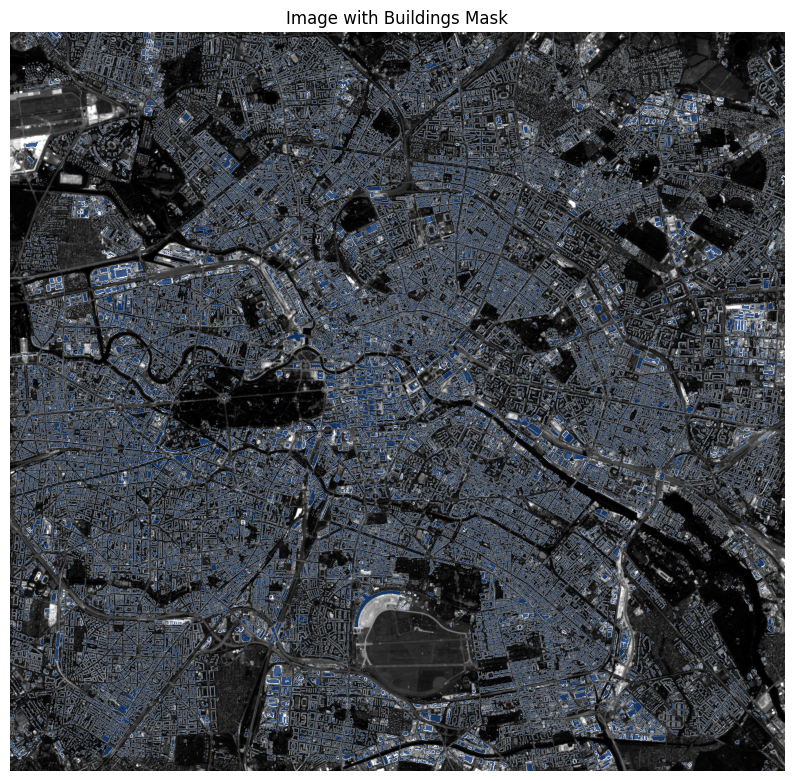

In [19]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
# Load the image
img = single_band_stretched  # Assuming `blue_stretched` is the single band image
with rasterio.open("data/BerlinTest/building_mask.tif") as ds_mask:
    mask = ds_mask.read(1)

blue_cmap = plt.cm.Blues
blue_building_mask = blue_cmap(mask / mask.max())
blue_building_mask[..., 3] = mask * 0.8 

# Plot the image
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray', alpha=1)

plt.imshow(blue_building_mask)

# Set the title and axis labels
plt.title('Image with Buildings Mask')
plt.axis('off')

# Show the plot
# plt.show()
plt.savefig(os.path.join(image_path_berlin, "BerlinTest_BuildingMaskOverlay.png"))
plt.close()